In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PySimpleGUI as sg

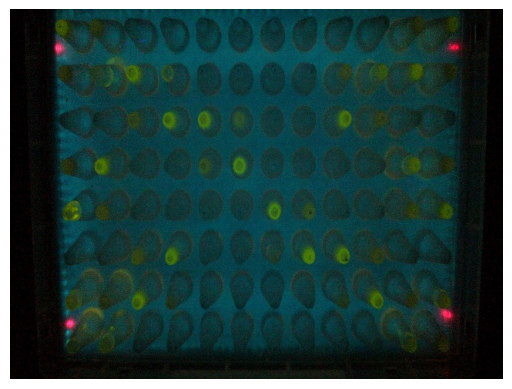

In [24]:
Img = "../data/images_12_11/red dot fixed.jpg"
imageInput = cv2.imread(Img)
imageInputRGB = cv2.cvtColor(imageInput, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(imageInputRGB)
plt.axis('off')
plt.show()

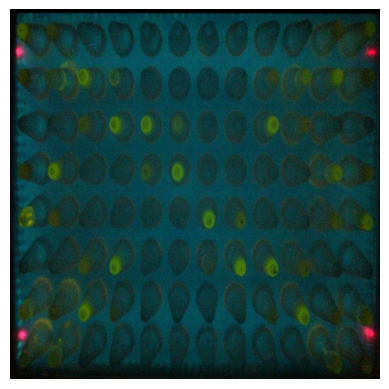

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = imageInput  # Input image

# Step 2: Split the image into Red, Green, and Blue channels
b, g, r = cv2.split(image)

# Step 3: Threshold the red channel to isolate "red" areas
_, red_mask = cv2.threshold(r, 100, 255, cv2.THRESH_BINARY)

# Step 4: Find contours in the red mask
contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Filter contours by area (only retain those with area > 50)
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 50]

# Step 6: Sort filtered contours by area and get the largest 4
filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:4]

# Step 7: Get the centers (centroids) of the largest 4 red dots
centroids = []
for contour in filtered_contours:
    # Calculate the moments to get the centroid (center) of the contour
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append([cX, cY])

# Step 8: Sort centroids into four groups: top-left, top-right, bottom-left, bottom-right
# Calculate the center of mass of the centroids
center_of_mass = np.mean(centroids, axis=0)

# Separate centroids into quadrants based on their relative position to the center of mass
top_left = [pt for pt in centroids if pt[0] < center_of_mass[0] and pt[1] < center_of_mass[1]]
top_right = [pt for pt in centroids if pt[0] > center_of_mass[0] and pt[1] < center_of_mass[1]]
bottom_left = [pt for pt in centroids if pt[0] < center_of_mass[0] and pt[1] > center_of_mass[1]]
bottom_right = [pt for pt in centroids if pt[0] > center_of_mass[0] and pt[1] > center_of_mass[1]]

# Now, we can select one point from each group, ideally the closest to the center of mass
top_left = min(top_left, key=lambda x: np.linalg.norm(np.array(x) - center_of_mass))
top_right = min(top_right, key=lambda x: np.linalg.norm(np.array(x) - center_of_mass))
bottom_left = min(bottom_left, key=lambda x: np.linalg.norm(np.array(x) - center_of_mass))
bottom_right = min(bottom_right, key=lambda x: np.linalg.norm(np.array(x) - center_of_mass))

# Create the ordered points for perspective transform
src_pts = np.float32([top_left, top_right, bottom_left, bottom_right])

# Define individual offsets for each corner
offset_top_left = np.array([-15, -55])  # Manually set the offset for top-left corner
offset_top_right = np.array([15, -55])  # Manually set the offset for top-right corner
offset_bottom_left = np.array([-15, 55])  # Manually set the offset for bottom-left corner
offset_bottom_right = np.array([15, 55])  # Manually set the offset for bottom-right corner

# Apply the individual offsets to each corner
src_pts[0] += offset_top_left    # Apply offset for top-left corner
src_pts[1] += offset_top_right   # Apply offset for top-right corner
src_pts[2] += offset_bottom_left # Apply offset for bottom-left corner
src_pts[3] += offset_bottom_right # Apply offset for bottom-right corner

# Define the destination points (You can modify this as needed, for example, a rectangle)
dst_pts = np.float32([[0, 0], [500, 0], [0, 500], [500, 500]])

# Step 9: Compute the perspective transform matrix
matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Step 10: Apply the perspective warp
warped_image = cv2.warpPerspective(image, matrix, (500, 500))

# Step 11: Convert the warped image from BGR to RGB for matplotlib
warped_image_rgb = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)

# Step 12: Show the warped image using matplotlib
plt.imshow(warped_image_rgb)
plt.axis('off')  # Hide axes
plt.show()


In [57]:
def color_grid(image, vertical_positions, horizontal_positions, cell_dict, binary_grid):
    for x in vertical_positions:
        cv2.line(image, (x, 0), (x, height), (255, 255, 255), 1)
    for y in horizontal_positions:
        cv2.line(image, (0, y), (width, y), (255, 255, 255), 1)

    grid_height = len(horizontal_positions) - 1
    grid_width = len(vertical_positions) - 1
    
    for i in range(grid_height):
        for j in range(grid_width):
            label = chr(65 + i) + str(j + 1)
            cell_dict[label] = {
                'x_start': vertical_positions[j],
                'x_end': vertical_positions[j + 1],
                'y_start': horizontal_positions[i],
                'y_end': horizontal_positions[i + 1]
            }
            
            # Get the color for the cell from the binary_grid
            text_color = (0, 255, 0) if binary_grid.get(label, 0) == 1 else (0, 0, 0)
            
            # Place the label on the image
            cv2.putText(image, label, 
                        (vertical_positions[j] + 5, horizontal_positions[i] + 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, text_color, 1)
    
    return cell_dict

def draw_grid(image, vertical_positions, horizontal_positions):
    for x in vertical_positions:
        cv2.line(image, (x, 0), (x, height), (255, 255, 255), 1)
    for y in horizontal_positions:
        cv2.line(image, (0, y), (width, y), (255, 255, 255), 1)
    cell_dict = {}
    grid_height = len(horizontal_positions) - 1
    grid_width = len(vertical_positions) - 1
    binary_grid = {}
    for i in range(grid_height):
        for j in range(grid_width):
            label = chr(65 + i) + str(j + 1)
            cell_dict[label] = {
                'x_start': vertical_positions[j],
                'x_end': vertical_positions[j + 1],
                'y_start': horizontal_positions[i],
                'y_end': horizontal_positions[i + 1]
            }
    return cell_dict

##############

imageInput = warped_image_rgb
# Convert to LAB color space and apply Gaussian blur
imageInput_blurred = cv2.GaussianBlur(imageInput, (5, 5), 3)
lab = cv2.cvtColor(imageInput_blurred, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

# Get image dimensions and define grid positions
height, width, _ = imageInput.shape
vertical_positions = [35, 80, 128, 175, 215, 260, 310, 360, 405, 455, 500, 545, 595]
horizontal_positions = [0, 60, 120, 175, 235, 300, 360, 425, 475]

# Draw grid and get coordinates of each cell
overlayed_image = np.where(cv2.cvtColor(cv2.threshold(b, 300, 255, cv2.THRESH_BINARY)[1], cv2.COLOR_GRAY2BGR) == 255, imageInput, cv2.convertScaleAbs(imageInput, alpha=0.3, beta=0))
cell_dict = draw_grid(overlayed_image, vertical_positions, horizontal_positions)
a1_coords = cell_dict["A1"]
a1_b_channel = b[a1_coords['y_start']:a1_coords['y_end'], a1_coords['x_start']:a1_coords['x_end']]
threshold_value = int(np.max(a1_b_channel)) - int(np.max(a1_b_channel)) * 0.05
print(threshold_value)
_, binary_mask = cv2.threshold(b, threshold_value, 255, cv2.THRESH_BINARY)

# Remove small noise using contour detection
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 100  # Minimum area to keep
for contour in contours:
    if cv2.contourArea(contour) < min_area:
        cv2.drawContours(binary_mask, [contour], -1, 0, -1)

# Darken the original image and apply the mask
darkened_image = cv2.convertScaleAbs(imageInput, alpha=0.3, beta=0)
binary_mask_colored = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
overlayed_image = np.where(binary_mask_colored == 255, imageInput, darkened_image)

binary_grid = {}
for cell_name, cell_coords in cell_dict.items():
    # Crop the binary mask for the current cell
    cell_mask = binary_mask[cell_coords['y_start']:cell_coords['y_end'], cell_coords['x_start']:cell_coords['x_end']]
    
    # Count white pixels in the cell
    positive_pixels = cv2.countNonZero(cell_mask)
    
    # Mark as 1 if positive sample is detected, otherwise 0
    binary_grid[cell_name] = 1 if positive_pixels > min_area else 0

# Step 2: Now draw the grid with the cell names colored according to binary_grid
cell_dict = color_grid(overlayed_image, vertical_positions, horizontal_positions, cell_dict, binary_grid)

# Display the binary grid result
print("Binary Grid (1 = Positive, 0 = Negative):")
for row in range(len(horizontal_positions) - 1):
    line = ""
    for col in range(len(vertical_positions) - 1):
        cell_name = chr(65 + row) + str(col + 1)
        line += f"{binary_grid[cell_name]} "
    print(line)

# Convert the image with grid overlay to a format suitable for PySimpleGUI
imageBytes = cv2.imencode('.png', overlayed_image)[1].tobytes()

# Create PySimpleGUI window to display the image
layout = [[sg.Image(data=imageBytes)]]
window = sg.Window('Image with Grid Overlay', layout, finalize=True)

# Event loop to keep the window open
while True:
    event, values = window.read()
    if event == sg.WIN_CLOSED:
        break

window.close()

158.65
Binary Grid (1 = Positive, 0 = Negative):
1 1 1 1 1 1 1 1 0 0 0 0 
1 1 1 1 1 1 1 1 1 0 0 0 
1 1 1 1 1 1 1 1 0 0 0 0 
1 1 1 1 1 1 1 1 1 0 0 0 
1 1 1 1 1 1 1 1 1 1 0 0 
1 0 1 1 1 1 1 1 1 1 0 0 
0 1 1 1 1 1 1 1 0 0 0 0 
0 0 1 1 1 1 1 1 0 0 0 0 


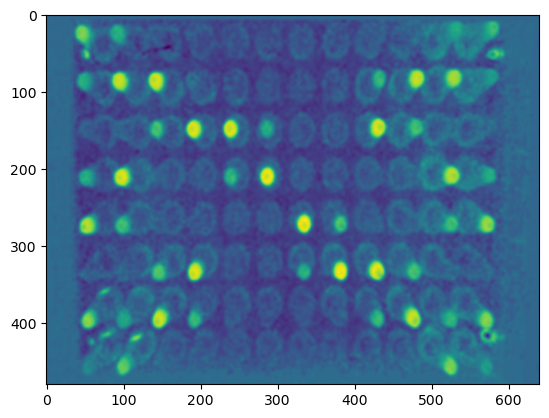

In [116]:
plt.imshow(l)

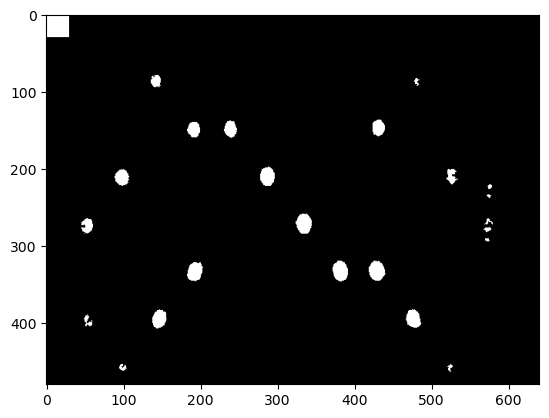

In [47]:
_, mask = cv2.threshold(a, 105, 150, cv2.THRESH_BINARY_INV)  # Adjust threshold as needed

# Find contours of the darker regions in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty mask to keep only large dots
large_dots_mask = np.zeros_like(mask)

# Loop through contours and keep only ones larger than 100 pixels
for contour in contours:
    if cv2.contourArea(contour) > 10:  # Filter by area size
        cv2.drawContours(large_dots_mask, [contour], -1, 255, thickness=cv2.FILLED)
plt.imshow(large_dots_mask, cmap='gray')


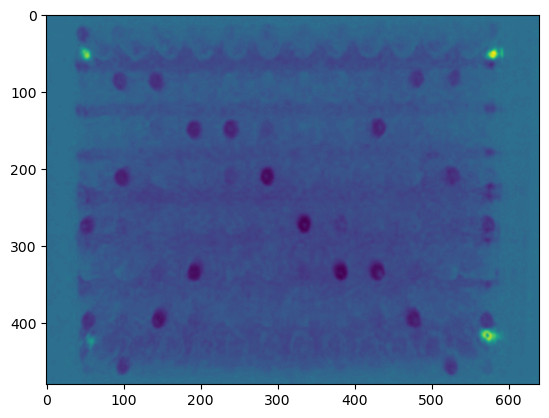

In [18]:
plt.imshow(a)

In [3]:
## TO JSON format
import json

# Convert the binary grid to a JSON-serializable format
grid_json = json.dumps(binary_grid, indent=4)

# Save JSON to a file
with open("binary_grid.json", "w") as f:
    f.write(grid_json)


In [ ]:
# ----- CLFA -------

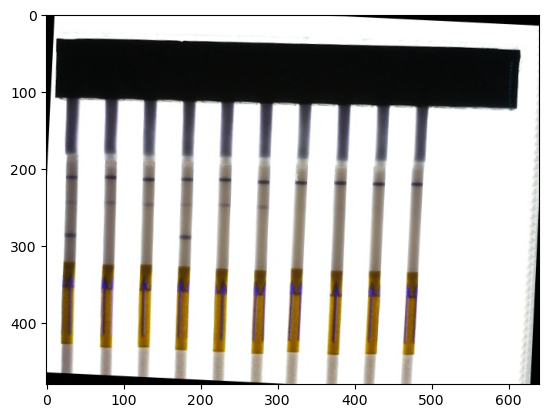

In [103]:
Img = "recent_correct_data/LFA_Br1_Cst1.jpg"
imageInput = cv2.imread(Img)
#imageInput_blurred = cv2.GaussianBlur(imageInput, (5, 5), 0)
lab = cv2.cvtColor(imageInput, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
plt.imshow(rotated_image)

/var/folders/gl/xp97kxjs0ys5qy6zk2zvvp4m0000gn/T/ipykernel_71010/2743232123.py:24: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


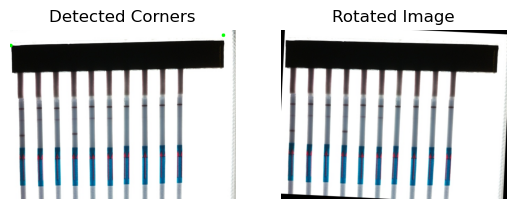

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
Img = "recent_correct_data/LFA_Br1_Cst1.jpg"
imageInput = cv2.imread(Img)

# Convert to grayscale
gray = cv2.cvtColor(imageInput, cv2.COLOR_BGR2GRAY)

# Apply threshold to isolate the black rectangle
_, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)  # Invert to focus on dark areas

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Identify the largest contour, assuming it's the black rectangle
largest_contour = max(contours, key=cv2.contourArea)

# Get the bounding rectangle's corners
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Sort corners to find top-left and top-right points
sorted_box = sorted(box, key=lambda x: x[1])  # Sort by y-coordinate to get top corners
top_left, top_right = sorted(sorted_box[:2], key=lambda x: x[0])  # Sort by x-coordinate for left and right

# Calculate angle for rotation
delta_y = top_right[1] - top_left[1]
delta_x = top_right[0] - top_left[0]
angle = np.degrees(np.arctan2(delta_y, delta_x))

# Get image center and rotate to align rectangle horizontally
(h, w) = imageInput.shape[:2]
center = (w // 2, h // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_image = cv2.warpAffine(imageInput, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

# Display original with detected corners and rotated result
for point in [top_left, top_right]:
    cv2.circle(imageInput, tuple(point), 5, (0, 255, 0), -1)  # Draw detected corner points

# Display the images
plt.subplot(1, 2, 1)
plt.title("Detected Corners")
plt.imshow(cv2.cvtColor(imageInput, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Rotated Image")
plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()
